In [69]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import simpy
import queue
import math
from scipy import stats

In [70]:
# Simulation parameters
simulationDuration = 1000  # Total simulation time
df_responseTimes = pd.DataFrame(columns=['time', 'traffic_class', 'response_time', 'burstiness'])
df_lossRates = pd.DataFrame(columns=['time', 'traffic_class', 'loss_rate'])

np.random.seed(10)

In [71]:
# Function to print loss rates periodically
seqno = 0  # Global sequence number for packet identification
periodPrintLR = 10

def print_loss_rate(env, source):
    global df_lossRates
    if source.nb_emissions > 0:  # Avoid division by zero
        df_lossRates.loc[len(df_lossRates)] = {
            'traffic_class': source.ident,
            'time': env.now,
            'loss_rate': source.queue_losses / source.nb_emissions  # Compute loss rate
        }


In [72]:
# Packet class to store packet attributes
class Packet:
    def __init__(self, t, ident, pkt_size):
        global seqno
        seqno += 1
        self.t = t  # Time of packet creation
        self.ident = ident  # Traffic class identifier
        self.pkt_size = pkt_size  # Packet size in bytes
        self.seqno = seqno  # Unique sequence number


In [73]:
# Queue class that simulates infinite buffer queue + server
class QueueClass:
    def __init__(self, env, service_rate, b):
        self.env = env  # Simulation environment
        self.in_service = 0  # Tracks if a packet is in service
        self.queue_capacity = float('inf')  # Infinite queue capacity
        self.service_rate = service_rate * 1e6  # Convert Mbps to bps
        self.burstiness_level = b
        self.buffer = queue.Queue(maxsize=int(1e7))  # Large capacity for approximation
        self.queue_length = 0  # Tracks total queue length
        self.cpterPrintLR = 0  # Counter for printing loss rate

    def service(self):
        if not self.buffer.empty():
            p = self.buffer.get_nowait()
            self.in_service = 1
            service_time = p.pkt_size * 8 / self.service_rate
            yield self.env.timeout(service_time)
            
            # Ensure burstiness is recorded correctly
            df_responseTimes.loc[len(df_responseTimes)] = {
                'time': self.env.now, 
                'traffic_class': p.ident, 
                'response_time': self.env.now - p.t,
                'burstiness': self.burstiness_level  # Ensure burstiness is logged
            }
            del p
            
            if not self.buffer.empty():
                self.env.process(self.service())
            else:
                self.in_service = 0


    def reception(self, source, pkt):
        if self.queue_length + pkt.pkt_size <= self.queue_capacity:
            self.queue_length += pkt.pkt_size
            self.buffer.put(pkt)  # Add packet to queue
            if self.in_service == 0:
                self.env.process(self.service())  # Start processing if idle
                print_loss_rate(self.env,source)
        else:
            source.queue_losses += 1  # Count lost packets
            print_loss_rate(self.env, source)

In [74]:
# Poisson source class to simulate traffic
class PoissonSource:
    def __init__(self, env, rate, queue, ident, pkt_size):
        self.env = env  # Simulation environment
        self.rate = rate  # Packet arrival rate
        self.q = queue  # Reference to queue
        self.ident = ident  # Traffic type identifier
        self.pkt_size = pkt_size  # Packet size in bytes
        self.nb_emissions = 0  # Total packets generated
        self.queue_losses = 0  # Count of dropped packets
        self.cpterPrintLR = 0  # Counter for loss rate printing
        self.action = env.process(self.run())  # Start packet generation
        
    def run(self):
        while self.env.now < simulationDuration:  # Stop packet generation at simulation end
            yield self.env.timeout(np.random.exponential(scale=1/self.rate))
            self.nb_emissions += 1
            if self.env.now < simulationDuration:  # Ensure packet is only sent within time limits
                p = Packet(self.env.now, self.ident, self.pkt_size)
                self.q.reception(self, p)

In [75]:
class BurstSource:
    def __init__(self, env, b, queue, ident, pkt_size, lambda_average):
        self.env = env
        self.b = b  # Burstiness factor
        self.q = queue
        self.ident = ident
        self.pkt_size = pkt_size
        self.lambda_average = lambda_average  # Average packet rate

        # Compute peak rate dynamically based on burstiness
        self.peak_rate = self.b * self.lambda_average

        # Compute ON and OFF periods based on burstiness
        self.on_time = 1e-3  # Fixed ON period (1 ms)
        self.off_time = (self.b - 1) * self.on_time  # OFF period scales with burstiness

        # Initialize state variables
        self.nb_emissions = 0
        self.queue_losses = 0
        self.is_on = False

        # Start the process
        self.action = env.process(self.run())

    def run(self):
        #print(f"🚀 BurstSource started for {self.ident} at time {self.env.now}")
        while self.env.now < simulationDuration:
            #print(f"⏳ BurstSource OFF period (waiting) at time {self.env.now}")
            # OFF period - No packets sent
            yield self.env.timeout(np.random.exponential(scale=self.off_time))
            self.is_on = True

            # ON period - Packets are sent at peak rate
            #print(f"🔥 BurstSource ON period (sending packets) at time {self.env.now}")
            on_end_time = self.env.now + np.random.exponential(scale=self.on_time)  # Define ON duration

            # Poisson-distributed packet emission during ON periods
            #print(f"🟢 Entering Packet Generation Loop at time {self.env.now}")
            while self.env.now < on_end_time:
                bit_rate = self.peak_rate * 1e6  # Convert peak rate from Mbps to bits per second
                packet_rate = bit_rate / (self.pkt_size * 8)  # Convert to packets per second
                timeout = np.random.exponential(scale=1/packet_rate)  # Generate correct inter-arrival times
                #print(f"TimeOut time in ON period: {timeout}")
                yield self.env.timeout(timeout)
                #print(f"🔍 Packet Check: is_on={self.is_on} at time {self.env.now}")
                if self.is_on:
                    p = Packet(self.env.now, self.ident, self.pkt_size)
                    #print(f"📦 Video Packet Generated at time {self.env.now}")
                    self.q.reception(self, p)
            self.is_on = False # Turn off source after ON period

In [76]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import simpy

def run_experiment(b_values, simulationDuration=100, num_blocks=10):
    results = []
    
    for b in b_values:
        print(f"Running simulation for burstiness b={b}")
        
        # Reset simulation environment
        env = simpy.Environment()
        queue = QueueClass(env, 100, b)  # 100 Mbps server

        # Define traffic sources
        data_source = PoissonSource(env, rate=30, queue=queue, ident='data', 
                                    pkt_size=np.random.choice([50, 500, 1500], p=[0.4, 0.3, 0.3]))
        voice_source = PoissonSource(env, rate=20, queue=queue, ident='voice', pkt_size=100)

        # Compute lambda_average for video traffic
        lambda_average = 30  # Define the expected average rate for video traffic
        video_source = BurstSource(env, b, queue, ident='video', pkt_size=1000, lambda_average=lambda_average)

        # Run the simulation
        env.run(until=simulationDuration)

        # Split simulation into `num_blocks` equal parts
        block_duration = simulationDuration / num_blocks

        for traffic_class in ['data', 'voice', 'video']:
            subset = df_responseTimes[df_responseTimes['traffic_class'] == traffic_class]
            
            if not subset.empty:
                mean_rt = subset['response_time'].mean()

                # Compute Z_t,i for each block
                block_means = []
                for i in range(num_blocks):
                    start_time = i * block_duration
                    end_time = (i + 1) * block_duration
                    block_data = subset[(subset['time'] >= start_time) & (subset['time'] < end_time)]
                    
                    if not block_data.empty:
                        block_means.append(block_data['response_time'].mean())

                if len(block_means) > 1:
                    std_t = np.std(block_means, ddof=1)  # Standard deviation of Z_t,i
                    epsilon_t = 2.576 * std_t  # Le Gall’s confidence interval 99%

                    results.append({
                        'b': b,
                        'traffic_class': traffic_class,
                        'mean_response_time': mean_rt,
                        'confidence_interval': (mean_rt - epsilon_t, mean_rt + epsilon_t)
                    })

    # Convert results to DataFrame
    experiment_results = pd.DataFrame(results)

    # Save results to CSV for further analysis
    experiment_results.to_csv("burstiness_results2.csv", index=False)
    print("Experiment results saved!")

    return experiment_results

b_values = [10, 30, 50, 70, 90]  # Different burstiness values to test
experiment_results = run_experiment(b_values)

Running simulation for burstiness b=10


KeyboardInterrupt: 

['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']
['data' 'video' 'voice']


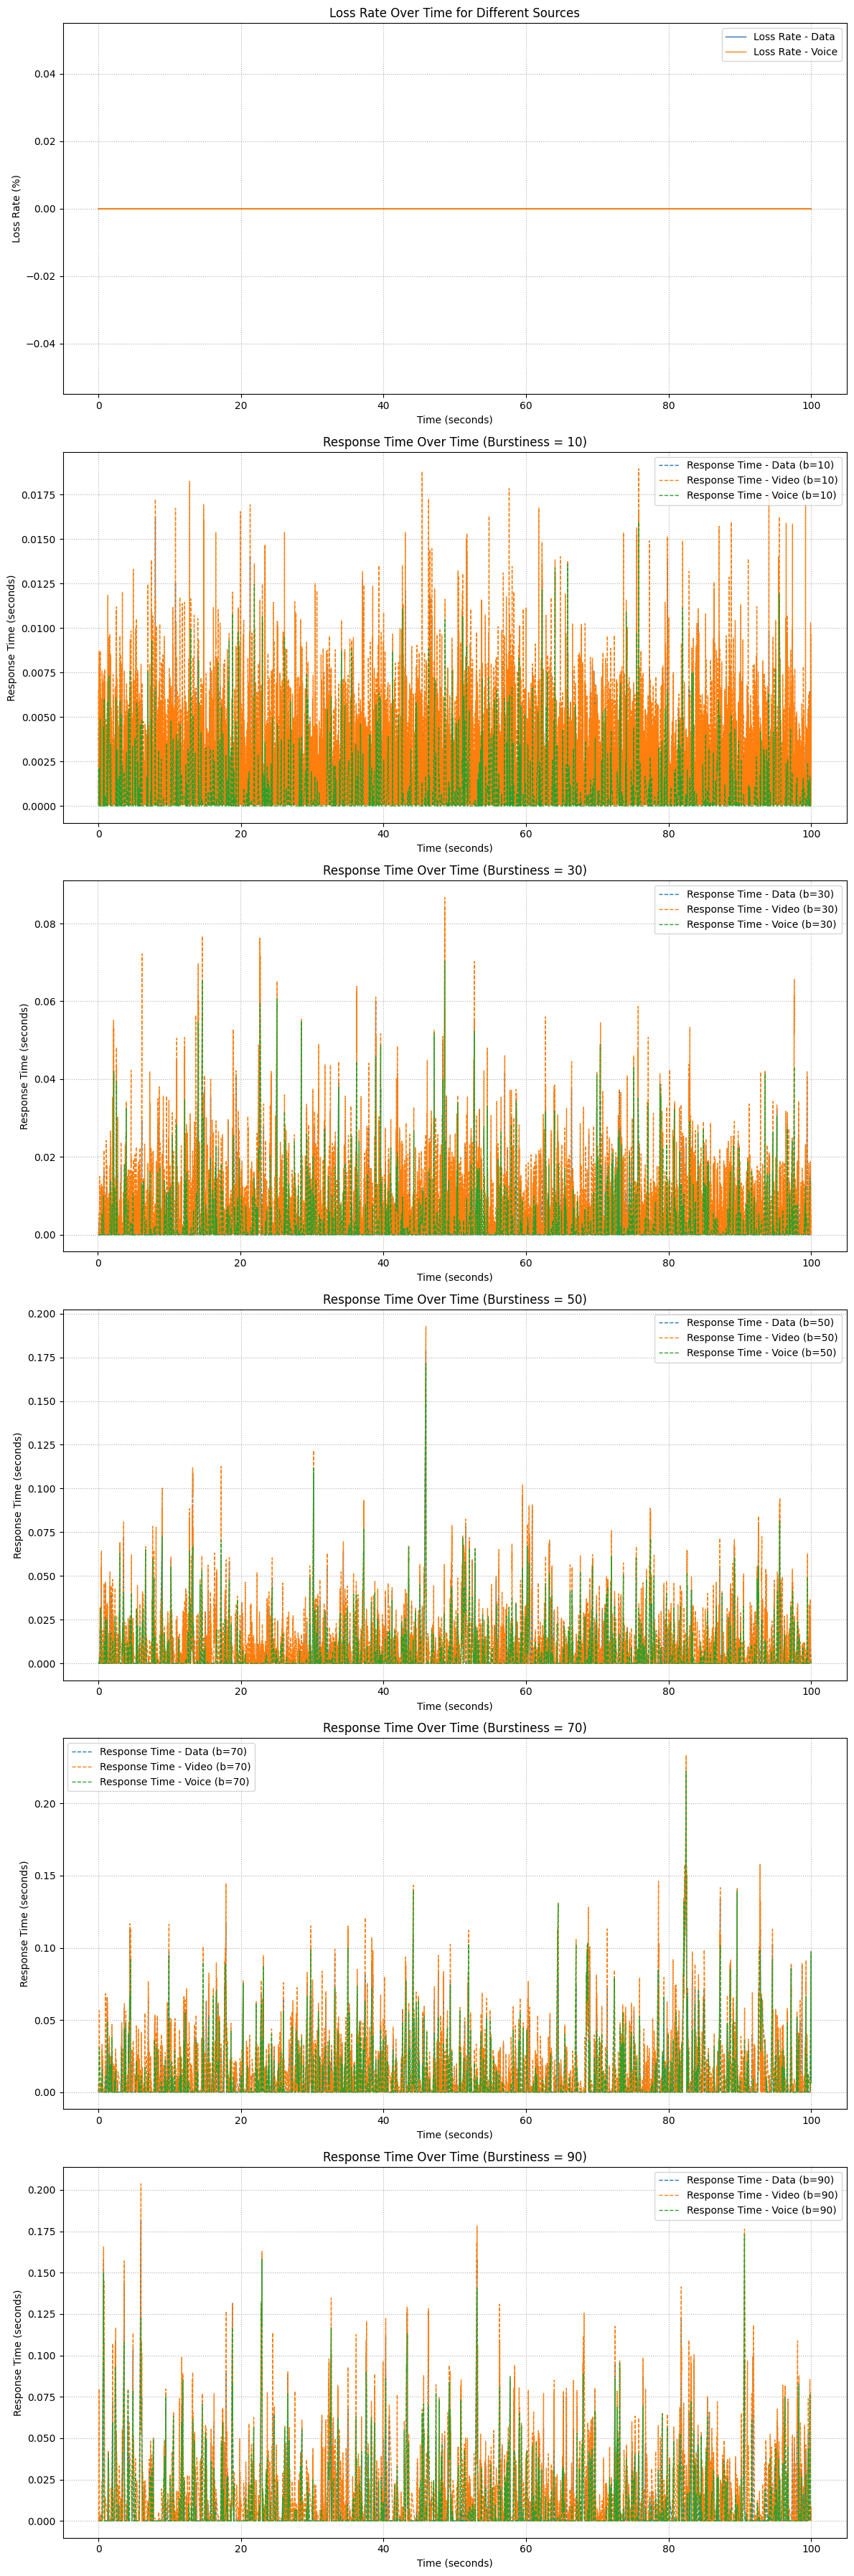

In [ ]:
# Get unique burstiness levels from experiment results
b_values = df_responseTimes['burstiness'].dropna().unique()

# Create figure with subplots for loss rate and response time
fig, axs = plt.subplots(len(b_values) + 1, 1, figsize=(12, 6 * (len(b_values) + 1)))

# ---- Loss Rate Plot (First subplot) ----
for traffic_class in ['data', 'video', 'voice']:
    if not df_lossRates[df_lossRates['traffic_class'] == traffic_class].empty:
        axs[0].plot(df_lossRates[df_lossRates['traffic_class'] == traffic_class]['time'],
                    df_lossRates[df_lossRates['traffic_class'] == traffic_class]['loss_rate'],
                    label=f"Loss Rate - {traffic_class.capitalize()}", linewidth=1)

axs[0].set_xlabel("Time (seconds)")
axs[0].set_ylabel("Loss Rate (%)")
axs[0].set_title("Loss Rate Over Time for Different Sources")
axs[0].legend()
axs[0].grid(True, linestyle='dotted')

# ---- Response Time Plots for each Burstiness Level ----
for i, b in enumerate(b_values):
    ax = axs[i + 1]  # Offset index since first plot is loss rate

    for traffic_class in ['data', 'video', 'voice']:
        filtered_data = df_responseTimes[(df_responseTimes['traffic_class'] == traffic_class) & (df_responseTimes['burstiness'] == b)]
        print(df_responseTimes['traffic_class'].unique())
        if not filtered_data.empty:
            ax.plot(filtered_data['time'], filtered_data['response_time'],
                    label=f"Response Time - {traffic_class.capitalize()} (b={b})", linestyle="dashed", linewidth=1)

    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Response Time (seconds)")
    ax.set_title(f"Response Time Over Time (Burstiness = {b})")
    ax.legend()
    ax.grid(True, linestyle='dotted')

plt.tight_layout()
plt.show()


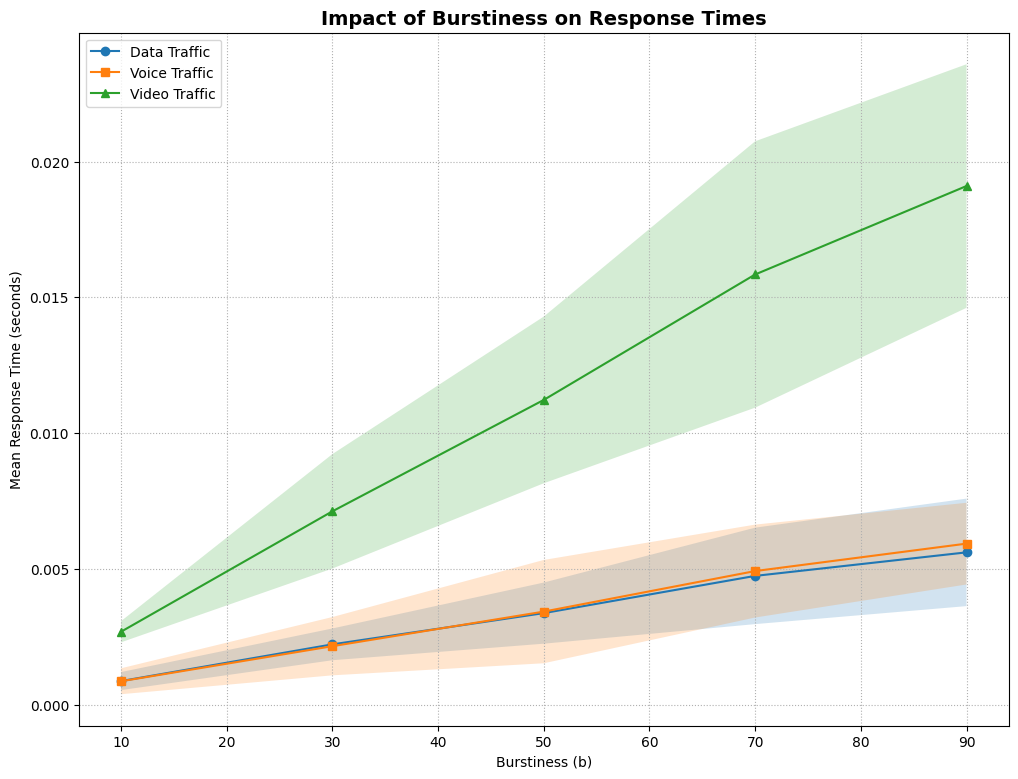

In [85]:
# Load experiment results
experiment_results = pd.read_csv("burstiness_results2.csv")

# Create figure for response time vs. burstiness
plt.figure(figsize=(12, 9))

# Plot response times with confidence intervals
for traffic_class, marker in zip(['data', 'voice', 'video'], ['o', 's', '^']):
    subset = experiment_results[experiment_results['traffic_class'] == traffic_class]

    if not subset.empty:
        plt.plot(subset['b'], subset['mean_response_time'], marker=marker, linestyle='-', label=f"{traffic_class.capitalize()} Traffic")

        # Extract confidence intervals
        ci_lower = subset['confidence_interval'].apply(lambda x: eval(x)[0])
        ci_upper = subset['confidence_interval'].apply(lambda x: eval(x)[1])

        # Add confidence interval shading
        plt.fill_between(subset['b'], ci_lower, ci_upper, alpha=0.2)

plt.xlabel("Burstiness (b)")
plt.ylabel("Mean Response Time (seconds)")
plt.title("Impact of Burstiness on Response Times",fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='dotted')

plt.show()

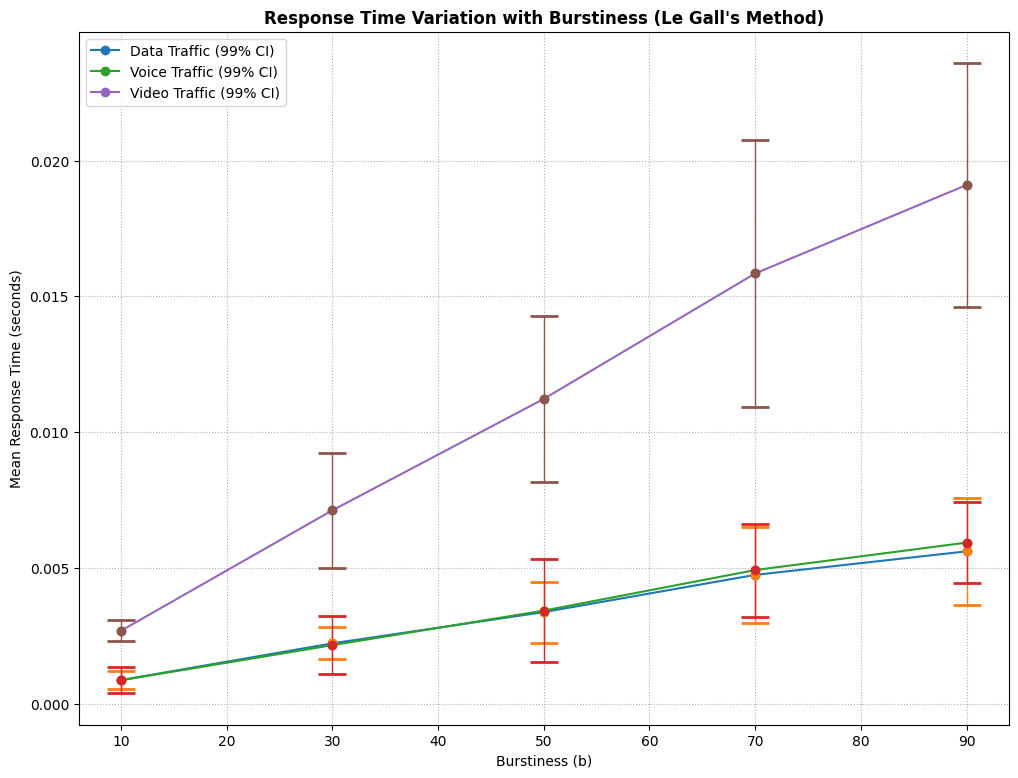

In [86]:
# Load the uploaded experiment results
experiment_results = experiment_results

# Extract unique traffic classes
traffic_classes = experiment_results['traffic_class'].unique()

# Create the plot
plt.figure(figsize=(12, 9))

# Plot response times with confidence intervals in the requested style
for traffic_class in traffic_classes:
    subset = experiment_results[experiment_results['traffic_class'] == traffic_class]
    b_values = subset['b']
    mean_response_times = subset['mean_response_time']
    ci_lower = [ci[0] for ci in subset['confidence_interval'].apply(eval)]
    ci_upper = [ci[1] for ci in subset['confidence_interval'].apply(eval)]
    
    # Plot mean response time
    plt.plot(b_values, mean_response_times, marker='o', linestyle='-', label=f"{traffic_class.capitalize()} Traffic", zorder=2)
    
    # Add discrete error bars instead of continuous CI shading
    plt.errorbar(b_values, mean_response_times, 
                 yerr=[mean_response_times - ci_lower, ci_upper - mean_response_times], 
                 fmt='o', capsize=10, capthick=2, elinewidth=1, zorder=10)

# Customize the plot
plt.xlabel("Burstiness (b)")
plt.ylabel("Mean Response Time (seconds)")
plt.title("Response Time Variation with Burstiness (Le Gall's Method)", fontsize=12, fontweight='bold')

# Include confidence interval notation in the legend
legend_labels = [f"{tc.capitalize()} Traffic (99% CI)" for tc in traffic_classes]
plt.legend(legend_labels, loc="upper left")

plt.grid(True, linestyle="dotted")

# Show the plot
plt.show()

In [87]:
print(df_lossRates.head())
print(df_responseTimes.head())
print(df_lossRates['time'].describe())
print(df_responseTimes['time'].describe())
print(df_responseTimes['burstiness'].unique())


       time traffic_class  loss_rate
0  0.000699          data        0.0
1  0.050208         voice        0.0
2  0.152947          data        0.0
3  0.166027          data        0.0
4  0.200335         voice        0.0
       time traffic_class  response_time  burstiness
0  0.000819          data       0.000120          10
1  0.012520         video       0.000080          10
2  0.012600         video       0.000122          10
3  0.012680         video       0.000197          10
4  0.012760         video       0.000274          10
count    489.000000
mean       7.274568
std        4.366625
min        0.000699
25%        3.402094
50%        7.093526
75%       11.031483
max       15.024597
Name: time, dtype: float64
count    60317.000000
mean         7.467564
std          4.323497
min          0.000819
25%          3.829018
50%          7.480434
75%         11.102688
max         15.082485
Name: time, dtype: float64
[10]
